In [1]:
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
from numpy import asarray
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
from keras.utils import np_utils
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from google.colab import drive
from keras.models import Sequential, load_model
from keras.applications.efficientnet_v2 import EfficientNetV2L
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv("/content/drive/MyDrive/Data mining proj/Radiology_manual_annotations.csv")
data = data.loc[data['Type'] == 'CESM']

In [6]:
allImages = []
train_images = []
test_images = []
val_images = []
train_img_array = []
test_img_array = []
val_img_array = []

img_size = 400

for i in data["Image_name"]:
  allImages.append(i.replace(" ", "")+".jpg")
allImages = allImages[1:-2]
print(len(allImages))

for i in range(int(0.7*(len(allImages)))):
  randNum = random.randint(0, len(allImages)-1)
  train_images.append(allImages[randNum])
  allImages.pop(randNum)

for i in range(int(0.7*(len(allImages)))):
  randNum = random.randint(0, len(allImages)-1)
  test_images.append(allImages[randNum])
  allImages.pop(randNum)

for i in allImages:
  val_images.append(i)

# load the image and convert into
# numpy array
for i in range(len(train_images)):
  img = Image.open('/content/drive/MyDrive/Data mining proj/Subtracted images of CDD-CESM/'+train_images[i])
  img = img.resize((img_size,img_size))
  numpydata = asarray(img)
  train_img_array.append(numpydata)

for i in range(len(test_images)):
  img = Image.open('/content/drive/MyDrive/Data mining proj/Subtracted images of CDD-CESM/'+test_images[i])
  img = img.resize((img_size,img_size))
  numpydata = asarray(img)
  test_img_array.append(numpydata)

for i in range(len(val_images)):
  img = Image.open('/content/drive/MyDrive/Data mining proj/Subtracted images of CDD-CESM/'+val_images[i])
  img = img.resize((img_size,img_size))
  numpydata = asarray(img)
  val_img_array.append(numpydata)

1000


In [7]:
label_train = []
label_test = []
label_val = []
counter = 0
loss_elements = []

for i in train_images:
  if data[data['Image_name']==i.replace(".jpg","")]['Pathology Classification/ Follow up'].size != 0:
    label = data[data['Image_name']==i.replace(".jpg","")]['Pathology Classification/ Follow up'].values[0]
    if(label=="Normal"):
      label_train.append(0)
    elif(label=="Benign"):
      label_train.append(1)
    elif(label=="Malignant"):
      label_train.append(2)
  else:
    loss_elements.append(counter)
  counter+=1
for i in loss_elements:
  train_img_array.pop(i)

loss_elements = []
counter = 0
for i in test_images:
  if data[data['Image_name']==i.replace(".jpg","")]['Pathology Classification/ Follow up'].size != 0:
    label = data[data['Image_name']==i.replace(".jpg","")]['Pathology Classification/ Follow up'].values[0]
    if(label=="Normal"):
      label_test.append(0)
    elif(label=="Benign"):
      label_test.append(1)
    elif(label=="Malignant"):
      label_test.append(2)
  else:
    loss_elements.append(counter)
  counter+=1

for i in loss_elements:
  test_img_array.pop(i)

loss_elements = []
counter = 0
for i in val_images:
  if data[data['Image_name']==i.replace(".jpg","")]['Pathology Classification/ Follow up'].size != 0:
    label = data[data['Image_name']==i.replace(".jpg","")]['Pathology Classification/ Follow up'].values[0]
    if(label=="Normal"):
      label_val.append(0)
    elif(label=="Benign"):
      label_val.append(1)
    elif(label=="Malignant"):
      label_val.append(2)
  else:
    loss_elements.append(counter)
  counter+=1

for i in loss_elements:
  val_img_array.pop(i)

(x_train,y_train),(x_test,y_test),(x_val,y_val)=(train_img_array, label_train),(test_img_array, label_test),(val_img_array,label_val)
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [8]:
for i in x_train:
  i = i/255.0
  i = i.astype('float32')

for i in x_test:
  i = i/255.0
  i = i.astype('float32')

for i in x_val:
  i = i/255.0
  i = i.astype('float32')

In [9]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [10]:
class_num = y_test.shape[1]

In [11]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:",tf.__version__)
print("HUB version:",hub.__version__)
print("GPU is","available" if tf.config.list_physical_devices('GPU') else "Not available")

TF version: 2.12.0
HUB version: 0.13.0
GPU is available


In [12]:
# base_model = EfficientNetV2L(weights=('imagenet') , include_top=False , input_shape=(img_size,img_size,3))

473176280/473176280 [==============================] - 3s 0us/step


In [13]:
# base_model.save('/content/drive/MyDrive/Data mining proj')

In [14]:
pre_trained_model = load_model('/content/drive/MyDrive/Data mining proj')

In [16]:
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
filepath = '/content/drive/MyDrive/Data mining proj/FinalModel/test.h5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

model = tf.keras.Sequential([
    hub.KerasLayer(pre_trained_model, trainable=False, dtype=tf.string),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(512, activation="LeakyReLU"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(256, activation="LeakyReLU"),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(3,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
  tf.keras.layers.Dense(3,activation="softmax")
])
model.build((None,)+(img_size,img_size)+(3,))
# model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate = 0.0002, momentum=0.01), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 13, 13, 1280)      117746848 
                                                                 
 flatten_1 (Flatten)         (None, 216320)            0         
                                                                 
 dropout_3 (Dropout)         (None, 216320)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               110756352 
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [18]:
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=20, batch_size=16, callbacks=[es])

Epoch 1/20
44/44 [==============================] - 41s 944ms/step - loss: 11.0443 - accuracy: 0.5465 - val_loss: 9.0541 - val_accuracy: 0.3778
Epoch 2/20
44/44 [==============================] - 41s 943ms/step - loss: 7.9992 - accuracy: 0.6180 - val_loss: 6.3968 - val_accuracy: 0.4333
Epoch 3/20
44/44 [==============================] - 41s 940ms/step - loss: 6.0903 - accuracy: 0.6609 - val_loss: 6.3256 - val_accuracy: 0.4556
Epoch 4/20
44/44 [==============================] - 41s 941ms/step - loss: 4.5624 - accuracy: 0.7039 - val_loss: 4.9696 - val_accuracy: 0.4889
Epoch 5/20
44/44 [==============================] - 41s 937ms/step - loss: 4.2712 - accuracy: 0.7053 - val_loss: 6.4031 - val_accuracy: 0.4667
Epoch 6/20
44/44 [==============================] - 41s 938ms/step - loss: 2.7184 - accuracy: 0.7926 - val_loss: 5.6686 - val_accuracy: 0.5111
Epoch 7/20
44/44 [==============================] - 40s 900ms/step - loss: 2.9902 - accuracy: 0.7825 - val_loss: 6.4866 - val_accuracy: 0.511

loss
accuracy
val_loss
val_accuracy


<Axes: >

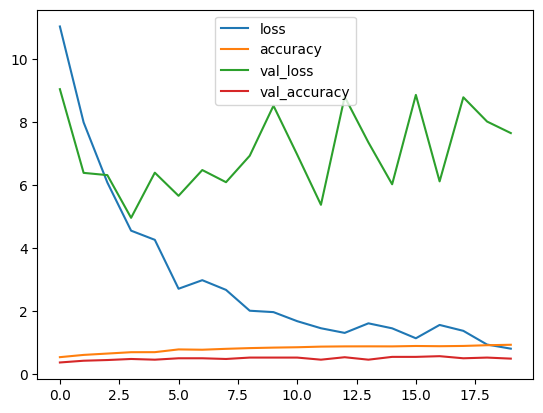

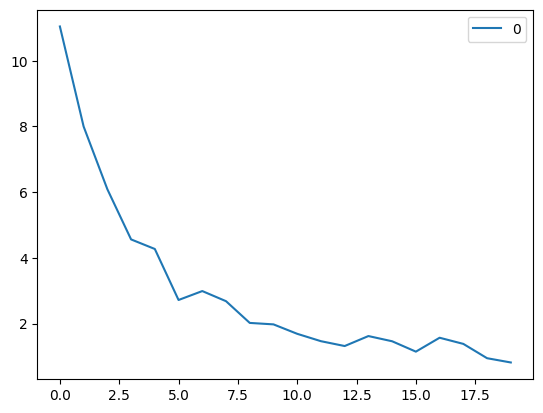

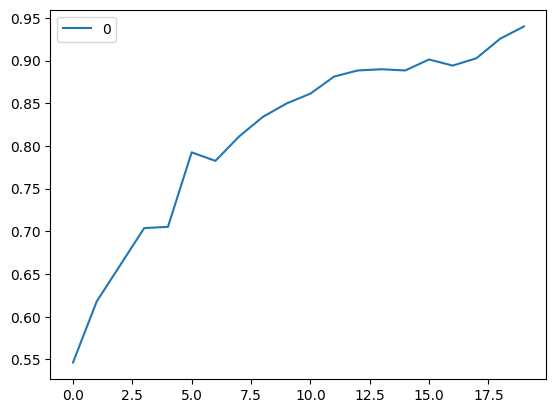

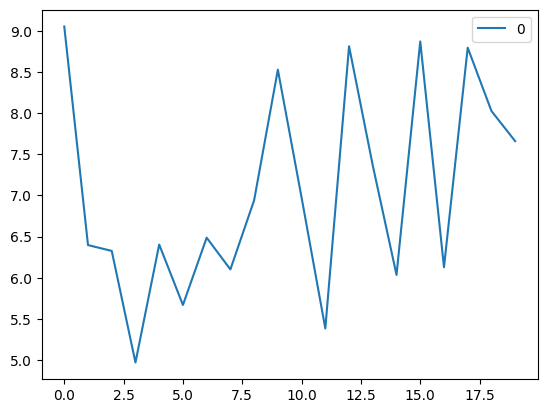

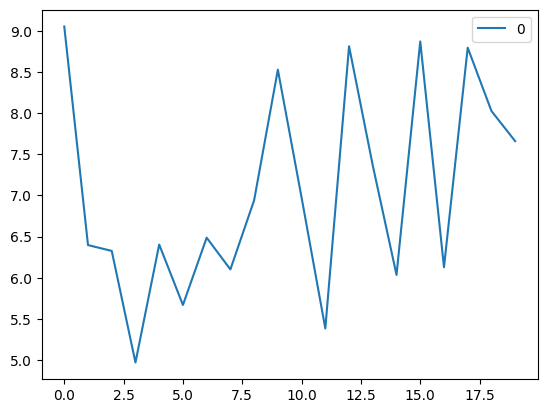

In [33]:
for key,val in history.history.items():
  print(key)

pd.DataFrame(history.history).plot()
pd.DataFrame(history.history["loss"]).plot()
pd.DataFrame(history.history["accuracy"]).plot()
pd.DataFrame(history.history["val_loss"]).plot()
pd.DataFrame(history.history["val_loss"]).plot()

In [ ]:
#model.save("/content/drive/MyDrive/Data mining proj/FinalModel/test.h5")

In [ ]:
# best_model = keras.models.load_model("/content/drive/MyDrive/Data mining proj/FinalModel/test.h5")

In [27]:
randNum = random.randint(0, len(test_img_array)-1)
x, y = (x_test[:1],y_test[1:])
results = model.evaluate(x_test, y_test, batch_size=16)
# model.predict(x)
# model.predict(y)

14/14 [==============================] - 8s 550ms/step - loss: 9.6208 - accuracy: 0.4211


In [28]:
model.predict(x_test)
model.predict(y_test)

7/7 [==============================] - 15s 2s/step


ValueError: ignored